Since g2 data from measurements are saved in .spe files so we import an external library to read such files to get data in numpy arrays.

In [13]:
# import libraries we need
%pylab inline
from implementations import sdt
import sys
sys.path.append('./sdt_reader/')
from tensorflow import keras

Populating the interactive namespace from numpy and matplotlib


In [2]:
# read data files
t1, y1 = sdt.read('./sdt_files/Antibunching_Rh110_DPC.sdt')
t2, y2 = sdt.read('./sdt_files/Antibunching_Rh110_Spc.sdt')

In [3]:
# cut off the first and last few zero data points
y2 = y2[np.argwhere(y2>0)].flatten()
t2 = t2[np.argwhere(y2>0)].flatten()

We need to manually set the dip as the zero time delay. And also normalize the g2 signal to its maximum.

In [4]:
# normalize g2 values and zero the time delay
t1_norm, y1_norm = sdt.normalize(t1,y1)
t2_norm, y2_norm = sdt.normalize(t2,y2)

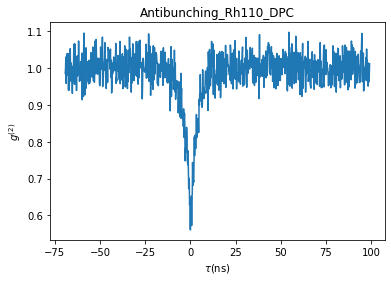

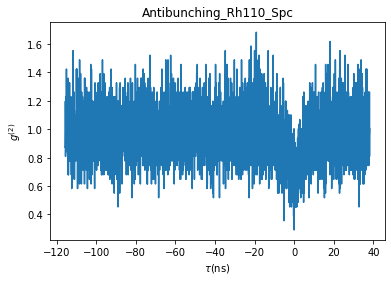

In [5]:
# take a look at the data
plt.figure(1)

plt.title('Antibunching_Rh110_DPC')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$') # un-normalized
plt.plot(t1_norm,y1_norm)

plt.figure(2)

plt.title('Antibunching_Rh110_Spc')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$')
plt.plot(t2_norm,y2_norm)
plt.show()

# MachineLearning Part

To avoid tensorflow occupying all CPUs or GPU in a computer we need to set processing units which tensorflow has access to use.

In [6]:
# this is to limit the GPU and CPUs being occupied by tensorflow
from implementations import tf_setCPU

In [21]:
# create training sequences
time_step = 5
train1 = sdt.create_train(y1,time_step)
#train2x, train2y = sdt.create_train(y1,time_step)

In [14]:
train1x.shape

(1019, 5)

Here I create a [1D CNN](https://keras.io/api/layers/convolution_layers/convolution1d/).

In [22]:
# create a training model
model = keras.Sequential()
model.add(keras.layers.Input(shape=(train1.shape)))
model.add(keras.layers.Conv1D(filters=32, kernel_size=5, padding="same", strides=2, activation="relu"))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Conv1DTranspose(filters=1, kernel_size=5, padding="same"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 510, 32)           832       
_________________________________________________________________
dropout_4 (Dropout)          (None, 510, 32)           0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 510, 1)            161       
Total params: 993
Trainable params: 993
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(train1,train1,epochs=20,validation_split=.1)

Epoch 1/20


ValueError: in user code:

    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/laserlab/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_6 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 5)


In [ ]:
history = model.fit(
    train1x,
    train1x,
    epochs=20,
    batch_size=128,
    validation_split=.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Get train MAE loss.
y_train_pred = model.predict()
train_mae_loss = np.mean(np.abs(), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


In [ ]:
# Get test MAE loss.
#f1_norm = f1_norm.reshape((f1_norm.shape,1))

y_test = create_sequences(y_norm,288)
y_test = np.stack(y_test)
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))
print('shape of test data: ',y_test.shape)

# time start
tstart_ml = time.time()
y_test_pred = model.predict(y_test)
test_mae_loss = np.mean(np.abs(y_test_pred - y_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))


In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
# time_step = 1000
anomalous_data_indices = []
for data_idx in range(time_step - 1, len(y_norm) - time_step + 1):
    if np.all(anomalies[data_idx - time_step + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print(anomalous_data_indices)


In [ ]:
plt.plot(t,y_norm,label='normal')
plt.plot(t[anomalous_data_indices],y_norm[anomalous_data_indices],'r',label='anomaly')
#plt.plot(g2_sim)
plt.legend()

tend_ml = time.time()
# time end

In [ ]:
# show the timing
fit_time = (tend_fit - tstart_fit) * 1000
MLpred_time = (tend_ml - tstart_ml) * 1000
print('time for fitting is: %1.4f ms'%(fit_time))
print('time for ML categorization is: %1.4f ms'%(MLpred_time))


In [ ]:
tic1 = time.time()
for i in range(100**2):
    pass
tic2 = time.time()
print((tic2-tic1)*1000,'ms')

In [ ]:
tic1 = time.clock()
for i in range(100**2):
    pass
tic2 = time.clock()
print((tic2-tic1)*1000,'ms')